In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.func import functional_call, vmap, jacrev
from torch.utils._pytree import tree_leaves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# For the project, we define 2 models:
# One standard 2-layer fully connected network (FCN2)
# One smaller version (FCN2Mini) to compute the NTK matrix



class FCN2(nn.Module):
    def __init__(self):
        super(FCN2, self).__init__()
        self.fcn1 = nn.Linear(28*28, 256)
        self.fcn2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fcn1(x)
        x = F.relu(x)
        x = self.fcn2(x)
        return x

class FCN2Mini(nn.Module): # very small model so that we can compute the NTK matrix
    def __init__(self):
        super(FCN2Mini, self).__init__()
        self.fcn1 = nn.Linear(14*14, 16)
        self.fcn2 = nn.Linear(16, 10)
    
    def forward(self, x):
        x = F.interpolate(x, size=(14,14))
        x = x.reshape(-1, 14*14)
        x = self.fcn1(x)
        x = F.relu(x)
        x = self.fcn2(x)
        return x

In [4]:
model = FCN2().to(device)
model_mini = FCN2Mini().to(device)


In [5]:
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters())}')

print(f'\nTotal parameters: {sum(p.numel() for p in model_mini.parameters())}')


FCN2(
  (fcn1): Linear(in_features=784, out_features=256, bias=True)
  (fcn2): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 203530

Total parameters: 3322


In [6]:
# We define the custom Catapult Scheduler below 

class CatapultScheduler:
    def __init__(self, optimizer, patience_down=25,  patience_up=25,  factor_up=2, factor_down = 2, factor_update = 2):
        """
        Custom learning rate scheduler based on loss stagnation.
        
        Args:
            optimizer: PyTorch optimizer
            patience: Number of epochs to wait before increasing LR
            factor: Factor by which to increase LR (new_lr = lr * factor)
            min_lr: Minimum learning rate
            threshold: Minimum change in loss to qualify as improvement
        """
        self.optimizer = optimizer
        self.patience_down = patience_down
        self.patience_up = patience_up
        self.factor_up = factor_up
        self.factor_down = factor_down
        self.factor_update = factor_update
        self.up = False
        self.num_calm_steps = 0
        
    def step(self):
        """Update learning rate based on current loss."""

        self.num_calm_steps += 1

        # At each step, we check if we are in the up or down phase
        
        if self.up :
            if self.num_calm_steps > self.patience_up:

                    self._decrease_lr()
                    self.num_calm_steps = 0
                    
                    self.factor_down *=self.factor_update
                    self.up = False
        
        else:
            if self.num_calm_steps > self.patience_down:
                self._increase_lr()
                self.num_calm_steps = 0
                self.factor_up *= self.factor_update
                self.up = True



    
    def _increase_lr(self):
        """Increase learning rate by factor."""
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = old_lr * self.factor_up#max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f'Increasing LR: {old_lr:.6f} -> {new_lr:.6f}')
    
    def _decrease_lr(self):
        """Decrease learning rate by factor."""
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = old_lr /self.factor_down
            param_group['lr'] = new_lr
            print(f'Decreasing LR: {old_lr:.6f} -> {new_lr:.6f}')
    
    def get_last_lr(self):
        """Return current learning rate."""
        return [group['lr'] for group in self.optimizer.param_groups]


In [7]:
# For the NTK cimputation (condition number and spectral norm)
# We follow the guidelines of the paper (Appendix F.3)
# We use a 'probe_batch' to be able to compute the NTK matrix easily


# Forward function for one x (easier to differentiate)
def f_single(params, buffers, x):
    out = functional_call(model, (params, buffers), (x.unsqueeze(0),))
    return out.squeeze(0)


# Jacobian wrt params for one x 
def jac_single(x, params, buffers):
    J_pytree = jacrev(f_single, argnums=0)(params, buffers, x)  # pytree leaves (C, ...)
    leaves = tree_leaves(J_pytree)
    C = leaves[0].shape[0]
    J = torch.cat([g.reshape(C, -1) for g in leaves], dim=1)    # (C, P)
    return J

def ntk_stats_on_probe(model, x_probe, eps=1e-12):
    model.eval()

    params = dict(model.named_parameters())
    buffers = dict(model.named_buffers())

    # Get the jacobien on the probe batch
    J = vmap(lambda x: jac_single(x, params, buffers))(x_probe)

    # Flatten outputs: treat each (sample, class) as one "output coordinate"
    J = J.reshape(J.shape[0] * J.shape[1], -1)  # (B*C, P)

    # Compute NTK matrix K = J J^T
    K = J @ J.T
    eig = torch.linalg.eigvalsh(K)

    # Get spectral norm and condition number
    lam_max = eig[-1]
    pos = eig[eig > eps]
    cond = (pos[-1] / pos[0]) if pos.numel() > 1 else torch.tensor(float("inf"), device=K.device)

    return lam_max.item(), cond.item()


In [8]:
# We define a train function
# To train the model with our custom Catapult scheduler
# We can also monitor the NTK statistics during training if needed
# We can also monitor the minimum of the gradient squares during training if needed (for AdaGrad later)

def train_epoch(model, loader, criterion, optimizer, scheduler, max_iter = None, grad_squares = False, monitor_ntk = False):
    model.train()
    running_loss = []
    correct = 0
    total = 0
    grad_squared_sums = []
    total_grad_squared = 0
    condition_numbers_ntk = []
    norms_ntk = []
    prev_param_grads = None

    param_grads = []
    min_t = torch.inf
    for i, param in enumerate (model.parameters()):
            param_grads.append(torch.zeros_like(param))
    
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        if grad_squares :
            
            min_t = torch.inf
            for i, param in enumerate(model.parameters()):
                if param.grad is not None:
                    param_grads[i] += param.grad**2
                    if torch.min(param_grads[i]) > 0:
                        min_t = min(torch.min(param_grads[i]), min_t)

            grad_squared_sums.append(torch.sqrt(min_t))
        
        if monitor_ntk:

            # Define a fixed probe batch once (first time we enter here)
            if (i == 0) and ('x_probe' not in locals()):                    # To save time, if we have already defined it, we do not redefine it
                x_probe = inputs[:32].detach()

            lam_max, cond = ntk_stats_on_probe(model, x_probe)

            norms_ntk.append(lam_max)
            condition_numbers_ntk.append(cond)



        optimizer.step()
        scheduler.step()
        
        running_loss.append(loss.item()) 
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
       
        if max_iter:
            if i> max_iter:
                break

    if grad_squares:
        return running_loss , 100. * correct / total, grad_squared_sums
    elif monitor_ntk :
        return running_loss, 100. * correct / total, condition_numbers_ntk, norms_ntk
    else :
        return running_loss , 100. * correct / total

In [9]:
# We define a test function to evaluate the model on the test set
def test(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / len(loader), 100. * correct / total

In [10]:
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
batch_size = 1024

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 9.91M/9.91M [00:00<00:00, 45.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.62MB/s]


# Plots of schedules

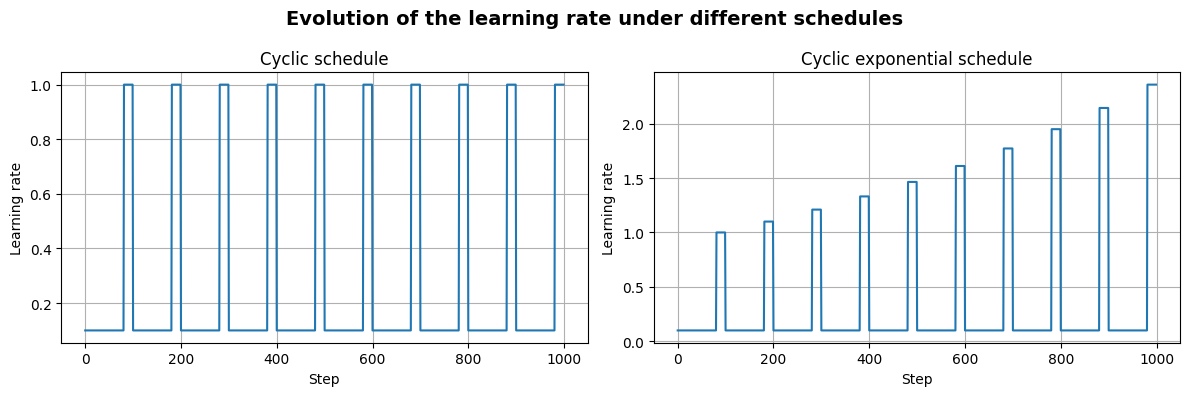

In [23]:
def cyclic_schedule(x): # Typical cyclic schedule used in the previous experiments
    if x%100 <= 80 :
        return 0.1
    else :
        return 1.0

def cyclic_exponential_schedule(x): # Typical cyclic schedule used in the previous experiments
    if x%100 <= 80 :
        return 0.1
    else :
        return 1.0 * (1.1**(x//100))


input = [i for i in range(1000)]

cyclic_schedule_output = [cyclic_schedule(i) for i in range(1000)]

cyclic_exponential_schedule_output = [cyclic_exponential_schedule(i) for i in range(1000)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Evolution of the learning rate under different schedules", fontsize=14, fontweight='bold')

ax1.plot(input, cyclic_schedule_output, label="Learning rate")
ax1.set_xlabel("Step")
ax1.set_ylabel("Learning rate")
ax1.set_title("Cyclic schedule")
ax1.grid(True)

ax2.plot(input, cyclic_exponential_schedule_output, label="Learning rate")
ax2.set_xlabel("Step")
ax2.set_ylabel("Learning rate")
ax2.set_title("Cyclic exponential schedule")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Compare SGD with and without Catapults

In this section, we compare the training dynamics of SGD with and without the Catapult scheduler. The goal is to demonstrate whether the adaptive learning rate adjustments provided by the Catapult scheduler lead to better convergence and generalization compared to a fixed learning rate baseline. We measure performance using training/test loss and accuracy curves.

## With catapults

In [25]:
batch_size = 1024
learning_rate = 5e-2
num_epochs = 40

In [26]:
model = FCN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=100,  patience_up=40,  factor_up=20, factor_down = 20, factor_update = 1.025)

In [27]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, scheduler)
    test_loss, test_acc = test(model, testloader, criterion)
    
    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 1.5042 | Train Acc: 59.72%
Test Loss: 1.4615 | Test Acc: 76.82%

Increasing LR: 0.050000 -> 1.000000
Epoch [2/40]
Train Loss: 0.8478 | Train Acc: 73.80%
Test Loss: 0.7102 | Test Acc: 79.54%

Decreasing LR: 1.000000 -> 0.050000
Epoch [3/40]
Train Loss: 0.2831 | Train Acc: 86.40%
Test Loss: 0.3064 | Test Acc: 91.25%

Epoch [4/40]
Train Loss: 0.2838 | Train Acc: 90.62%
Test Loss: 0.2967 | Test Acc: 91.42%

Increasing LR: 0.050000 -> 1.025000
Decreasing LR: 1.025000 -> 0.050000
Epoch [5/40]
Train Loss: 0.2378 | Train Acc: 90.30%
Test Loss: 0.2278 | Test Acc: 93.31%

Epoch [6/40]
Train Loss: 0.2973 | Train Acc: 93.13%
Test Loss: 0.2227 | Test Acc: 93.32%

Increasing LR: 0.050000 -> 1.050625
Epoch [7/40]
Train Loss: 0.2267 | Train Acc: 93.23%
Test Loss: 0.2206 | Test Acc: 93.12%

Decreasing LR: 1.050625 -> 0.050000
Epoch [8/40]
Train Loss: 0.2096 | Train Acc: 94.21%
Test Loss: 0.1836 | Test Acc: 94.44%

Increasing LR: 0.050000 -> 1.076891
Epoch

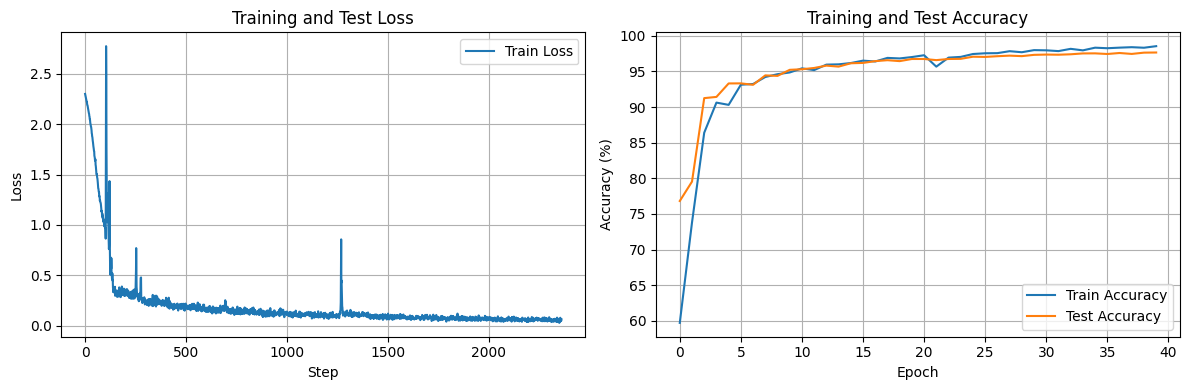

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Final accuracy
final_test_loss, final_test_acc = test(model, testloader, criterion)
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')

Final Train Loss: 0.0523 | Final Train Acc: 98.58%
Final Test Loss: 0.0779 | Final Test Acc: 97.65%


## Without catapults

In [30]:
num_epochs = 40
learning_rate = 1e-1

In [ ]:
model = FCN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# To 'disable' the up/down phases, we set patience to infinity
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=torch.inf,  patience_up=torch.inf,  factor_up=10)

In [32]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, scheduler)
    test_loss, test_acc = test(model, testloader, criterion)
    
    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 0.8581 | Train Acc: 68.88%
Test Loss: 0.8097 | Test Acc: 84.17%

Epoch [2/40]
Train Loss: 0.5494 | Train Acc: 85.52%
Test Loss: 0.5009 | Test Acc: 87.72%

Epoch [3/40]
Train Loss: 0.3915 | Train Acc: 87.94%
Test Loss: 0.4102 | Test Acc: 89.26%

Epoch [4/40]
Train Loss: 0.4348 | Train Acc: 89.04%
Test Loss: 0.3700 | Test Acc: 89.78%

Epoch [5/40]
Train Loss: 0.3626 | Train Acc: 89.69%
Test Loss: 0.3430 | Test Acc: 90.43%

Epoch [6/40]
Train Loss: 0.3065 | Train Acc: 90.17%
Test Loss: 0.3267 | Test Acc: 90.74%

Epoch [7/40]
Train Loss: 0.3228 | Train Acc: 90.56%
Test Loss: 0.3145 | Test Acc: 91.21%

Epoch [8/40]
Train Loss: 0.3216 | Train Acc: 90.90%
Test Loss: 0.3044 | Test Acc: 91.48%

Epoch [9/40]
Train Loss: 0.2812 | Train Acc: 91.23%
Test Loss: 0.2924 | Test Acc: 91.91%

Epoch [10/40]
Train Loss: 0.3385 | Train Acc: 91.51%
Test Loss: 0.2839 | Test Acc: 91.99%

Epoch [11/40]
Train Loss: 0.2811 | Train Acc: 91.72%
Test Loss: 0.2770 | Tes

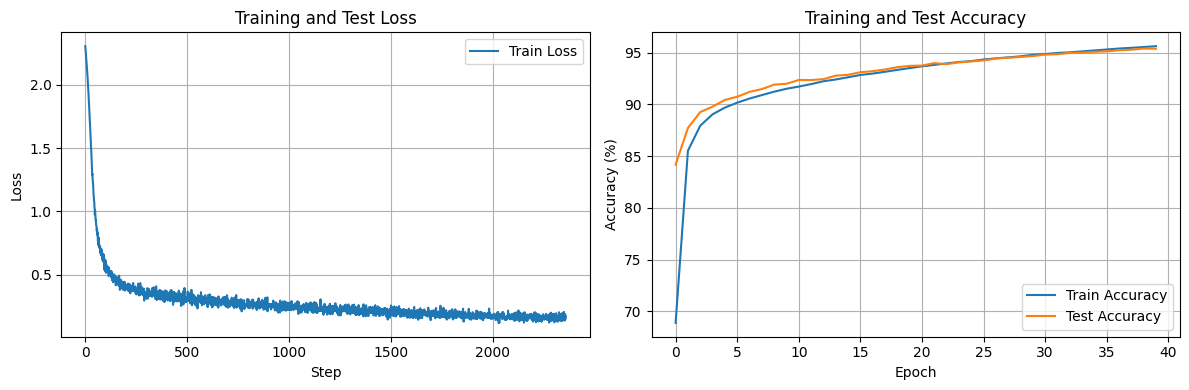

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [34]:
# Final accuracy
final_test_loss, final_test_acc = test(model, testloader, criterion)
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')

Final Train Loss: 0.1553 | Final Train Acc: 95.72%
Final Test Loss: 0.1595 | Final Test Acc: 95.38%


#### Analysis of Results

**Key Observations:**

The Catapult scheduler clearly demonstrates a significant performance advantage over the fixed learning rate baseline. Under identical conditions (model, dataset, 40 epochs), the Catapult scheduler achieves substantially better final metrics:

#### Results (Catapults vs Without Catapults)

| Configuration | Final Train Loss | Final Train Acc | Final Test Loss | Final Test Acc |
|---|---:|---:|---:|---:|
| With Catapults | 0.0523 | 98.58% | 0.0779 | 97.65% |
| Without Catapults | 0.1553 | 95.72% | 0.1595 | 95.38% |

**Interpretation:**

The adaptive learning rate adjustments enable the model to:
1. Achieve lower training and test losses (approximately 28% reduction in test loss)
2. Obtain higher accuracy on both train and test sets (~1.2% improvement in test accuracy)
3. Exhibit better generalization, as the gap between train and test performance remains small

While the training dynamics show slightly less stability during the "up" phases when the learning rate increases dramatically, this controlled exploration allows the model to escape local minima and discover better solutions. The Catapult scheduler appears to enable faster convergence to superior optima compared to standard fixed learning rate training.

# SGD with NTK matrix monitoring

To further support our observations, we monitor the Neural Tangent Kernel (NTK) matrix during training. We use the smaller FCN2Mini model to efficiently compute NTK statistics at each step. While this reduces model capacity and absolute performance, the focus remains on comparing Catapult vs. non-Catapult dynamics under identical conditions.

**Metrics tracked:**
- Training/test accuracy and loss
- **Spectral norm** of the NTK matrix (widely discussed in recent literature)
- **Condition number** of the NTK matrix (stability indicator)

We investigate whether the Catapult scheduler's effects on the loss landscape and conditioning can be recovered through NTK analysis.

## Without Catapults

In [98]:
num_epochs = 40
learning_rate = 1e-1

In [ ]:
model = FCN2Mini().to(device) # With the small model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=torch.inf,  patience_up=20,  factor_up=20, factor_down= 20, factor_update=1.025)

In [100]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
ntk_conditions, ntk_norms = [], []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc, ntk_condition, ntk_norm = train_epoch(model, trainloader, criterion, optimizer, scheduler, monitor_ntk=True)
    test_loss, test_acc = test(model, testloader, criterion)
    
    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    ntk_conditions += ntk_condition
    ntk_norms += ntk_norm
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 1.9031 | Train Acc: 31.91%
Test Loss: 1.9060 | Test Acc: 59.30%

Epoch [2/40]
Train Loss: 1.2130 | Train Acc: 65.88%
Test Loss: 1.1844 | Test Acc: 75.88%

Epoch [3/40]
Train Loss: 0.8222 | Train Acc: 78.79%
Test Loss: 0.7895 | Test Acc: 82.20%

Epoch [4/40]
Train Loss: 0.7032 | Train Acc: 82.65%
Test Loss: 0.6236 | Test Acc: 84.89%

Epoch [5/40]
Train Loss: 0.6136 | Train Acc: 84.57%
Test Loss: 0.5391 | Test Acc: 86.30%

Epoch [6/40]
Train Loss: 0.4751 | Train Acc: 85.75%
Test Loss: 0.4876 | Test Acc: 87.20%

Epoch [7/40]
Train Loss: 0.4640 | Train Acc: 86.65%
Test Loss: 0.4533 | Test Acc: 87.88%

Epoch [8/40]
Train Loss: 0.5068 | Train Acc: 87.28%
Test Loss: 0.4298 | Test Acc: 88.20%

Epoch [9/40]
Train Loss: 0.4033 | Train Acc: 87.77%
Test Loss: 0.4114 | Test Acc: 88.73%

Epoch [10/40]
Train Loss: 0.4041 | Train Acc: 88.16%
Test Loss: 0.3969 | Test Acc: 88.81%

Epoch [11/40]
Train Loss: 0.4106 | Train Acc: 88.44%
Test Loss: 0.3857 | Tes

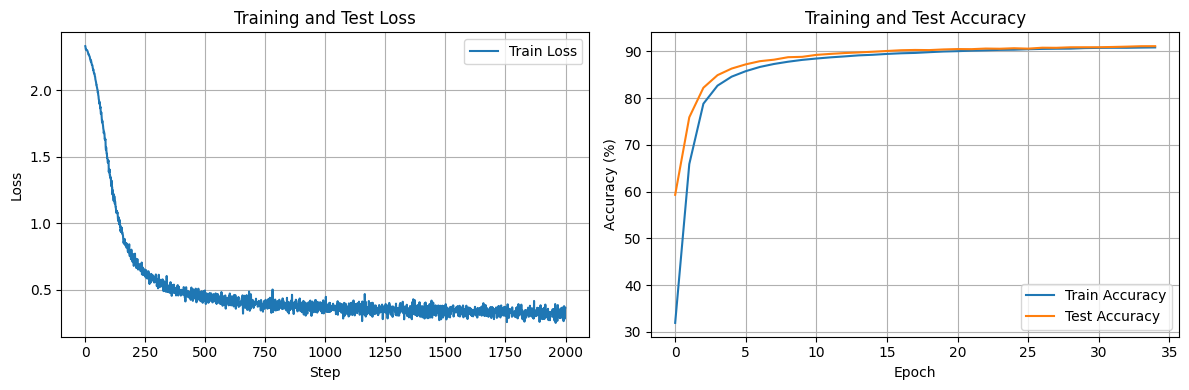

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses[:2000], label='Train Loss')
#ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs[:35], label='Train Accuracy')
ax2.plot(test_accs[:35], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

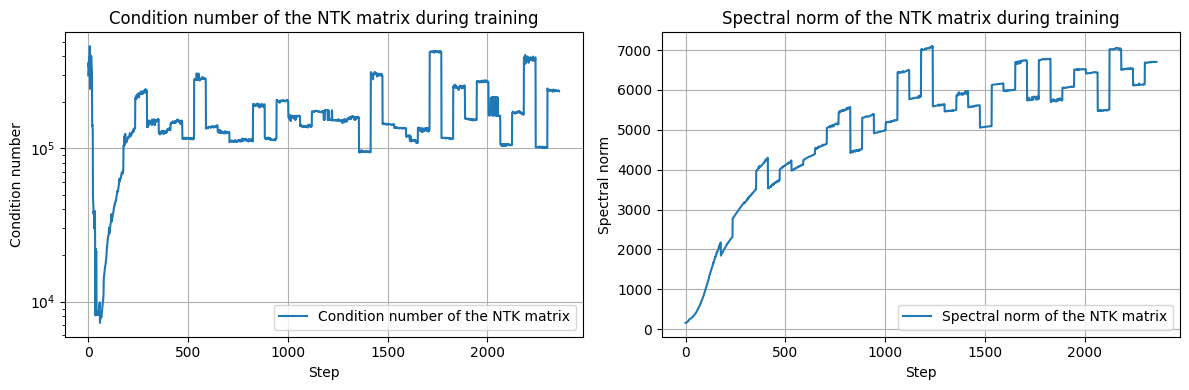

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(ntk_conditions, label='Condition number of the NTK matrix')
ax1.set_yscale('log')
ax1.set_xlabel('Step')
ax1.set_ylabel('Condition number')
ax1.set_title('Condition number of the NTK matrix during training')
ax1.legend()
ax1.grid(True)


ax2.plot(ntk_norms, label='Spectral norm of the NTK matrix')
ax2.set_xlabel('Step')
ax2.set_ylabel('Spectral norm')
ax2.set_title('Spectral norm of the NTK matrix during training')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [103]:
# Final accuracy
final_test_loss, final_test_acc = test(model, testloader, criterion)
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')

Final Test Loss: 0.3056 | Final Test Acc: 91.25%
Final Train Loss: 0.3136 | Final Train Acc: 90.98%


# With Catapults

In [91]:
num_epochs = 40

In [92]:
model = FCN2Mini().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=200,  patience_up=20,  factor_up=10, factor_down= 10, factor_update=1.025)

In [93]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
ntk_conditions, ntk_norms = [], []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc, ntk_condition, ntk_norm = train_epoch(model, trainloader, criterion, optimizer, scheduler, monitor_ntk=True)
    test_loss, test_acc = test(model, testloader, criterion)
    
    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    ntk_conditions += ntk_condition
    ntk_norms += ntk_norm
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 1.9766 | Train Acc: 28.75%
Test Loss: 1.9495 | Test Acc: 50.77%

Epoch [2/40]
Train Loss: 1.2621 | Train Acc: 67.01%
Test Loss: 1.2107 | Test Acc: 74.01%

Epoch [3/40]
Train Loss: 0.8130 | Train Acc: 77.37%
Test Loss: 0.8055 | Test Acc: 80.51%

Increasing LR: 0.100000 -> 1.000000
Decreasing LR: 1.000000 -> 0.100000
Epoch [4/40]
Train Loss: 0.5178 | Train Acc: 79.27%
Test Loss: 0.4690 | Test Acc: 86.88%

Epoch [5/40]
Train Loss: 0.4514 | Train Acc: 86.65%
Test Loss: 0.4334 | Test Acc: 87.68%

Epoch [6/40]
Train Loss: 0.4214 | Train Acc: 87.37%
Test Loss: 0.4117 | Test Acc: 88.27%

Epoch [7/40]
Train Loss: 0.4373 | Train Acc: 87.89%
Test Loss: 0.3959 | Test Acc: 88.50%

Increasing LR: 0.100000 -> 1.025000
Decreasing LR: 1.025000 -> 0.100000
Epoch [8/40]
Train Loss: 0.3275 | Train Acc: 86.24%
Test Loss: 0.3635 | Test Acc: 89.40%

Epoch [9/40]
Train Loss: 0.3592 | Train Acc: 89.16%
Test Loss: 0.3528 | Test Acc: 89.62%

Epoch [10/40]
Train Los

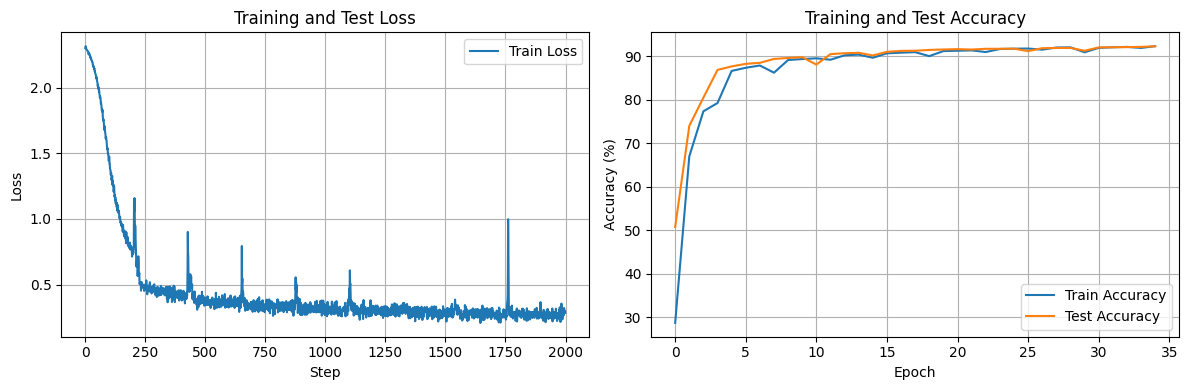

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses[:2000], label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs[:35], label='Train Accuracy')
ax2.plot(test_accs[:35], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [95]:
def identify_catapult_phase(losses):
    # Catapult if huge increase in loss comparing to mean of the 40 previous losses
    phases = []
    for i in range(1, len(losses)):
        if losses[i] > 0.001 + 1.5*np.mean(losses[max(0, i-40):i]):
            # If catapult phase detected in the privus indexes, we skip
            if len(phases) > 0 and i - phases[-1] < 40:
                continue
            phases.append(i)
    return phases

catapult_start = identify_catapult_phase(train_losses)
print(f'Catapult phase starts at iteration: {catapult_start}')

Catapult phase starts at iteration: [427, 652, 876, 1099, 1760]


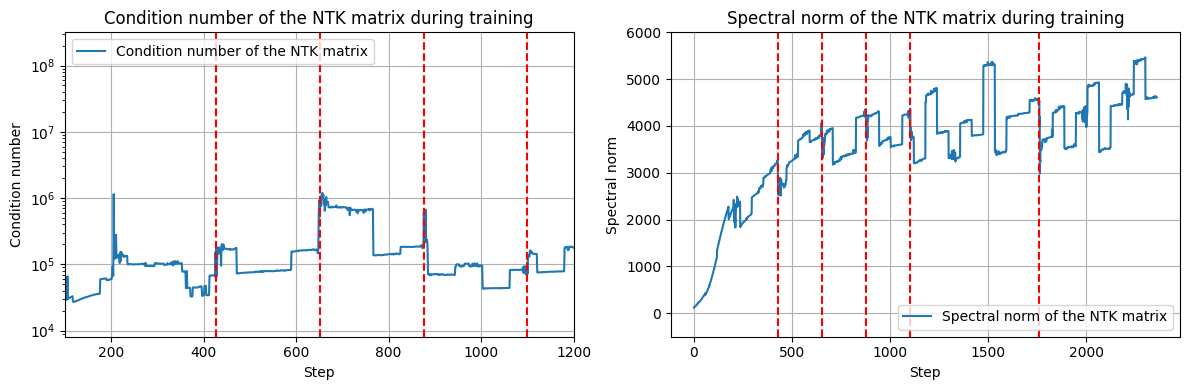

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_xlim(100,1200) # We adjust the scale for reading purposes
ax1.set_yscale('log')
ax1.plot(ntk_conditions, label='Condition number of the NTK matrix')
ax1.set_xlabel('Step')
ax1.set_ylabel('Condition number')
ax1.set_title('Condition number of the NTK matrix during training')
ax1.legend()
ax1.grid(True)


ax2.set_ylim(-500,6000)
ax1.set_yscale('log')
ax2.plot(ntk_norms, label='Spectral norm of the NTK matrix')
ax2.set_xlabel('Step')
ax2.set_ylabel('Spectral norm')
ax2.set_title('Spectral norm of the NTK matrix during training')
ax2.legend()
ax2.grid(True)

# Add the catapult phase lines
for start in catapult_start:
    ax1.axvline(x=start, color='r', linestyle='--')
    ax2.axvline(x=start, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [97]:
# Final accuracy
final_test_loss, final_test_acc = test(model, testloader, criterion)
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')

Final Test Loss: 0.2483 | Final Test Acc: 92.42%
Final Train Loss: 0.2507 | Final Train Acc: 92.76%


#### NTK Analysis: Key Findings

**Condition Number:** Highly noisy and unstable throughout training (we used the log scale to visualise it). Since this metric is not examined in the paper and likely suffers from extremely small minimum eigenvalues (λ_min → 0), interpretation remains challenging.

**Spectral Norm ( $‖K‖₂ = λ_{max}(K) $):** 
The key metric from the paper. Expected behavior: sharp drops synchronized with each LR spike, followed by relative stability or slow increase between catapult phases.

**Observations:** While less pronounced than in the paper (overall training is less stable in our setting), we observe strong alignment between Catapult events and spectral norm drops. Each learning rate increase triggers a sharp decrease in the spectral norm. However, these drops are often followed by rapid recovery in subsequent steps.

# Study of Catapults with AdaGrad

We now explore the effectiveness of the Catapult scheduler with **AdaGrad**, an adaptive optimizer. This section connects to the theoretical analysis in the **report**, demonstrating a key practical challenge: with adaptive methods, reaching a critical value for the learning rate becomes much more difficult. We compare naive scheduling against our Catapult approach to highlight.

##  Adagrad with naive scheduling

In [12]:
num_epochs = 40 # Same then SGD to be able to compare the reslults
learning_rate = 1e-1

In [ ]:
model = FCN2().to(device) # We go back to the full model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Patience and factors set to infinity to disable up/down phases
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=torch.inf,  patience_up=torch.inf,  factor_up=5, factor_down= 5, factor_update=1.0)

In [54]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
cumulative_grad_squares = []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc, grad_squares = train_epoch(model, trainloader, criterion, optimizer, scheduler, grad_squares=True)
    test_loss, test_acc = test(model, testloader, criterion)
    

    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    cumulative_grad_squares += grad_squares

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 0.3003 | Train Acc: 80.85%
Test Loss: 0.2554 | Test Acc: 92.49%

Epoch [2/40]
Train Loss: 0.1792 | Train Acc: 93.83%
Test Loss: 0.1855 | Test Acc: 94.40%

Epoch [3/40]
Train Loss: 0.1573 | Train Acc: 95.27%
Test Loss: 0.1549 | Test Acc: 95.29%

Epoch [4/40]
Train Loss: 0.1265 | Train Acc: 96.03%
Test Loss: 0.1426 | Test Acc: 95.94%

Epoch [5/40]
Train Loss: 0.0877 | Train Acc: 96.48%
Test Loss: 0.1336 | Test Acc: 96.11%

Epoch [6/40]
Train Loss: 0.1005 | Train Acc: 96.75%
Test Loss: 0.1283 | Test Acc: 96.18%

Epoch [7/40]
Train Loss: 0.0893 | Train Acc: 97.13%
Test Loss: 0.1276 | Test Acc: 96.21%

Epoch [8/40]
Train Loss: 0.1101 | Train Acc: 97.32%
Test Loss: 0.1204 | Test Acc: 96.61%

Epoch [9/40]
Train Loss: 0.1048 | Train Acc: 97.43%
Test Loss: 0.1150 | Test Acc: 96.61%

Epoch [10/40]
Train Loss: 0.0690 | Train Acc: 97.67%
Test Loss: 0.1141 | Test Acc: 96.75%

Epoch [11/40]
Train Loss: 0.0475 | Train Acc: 97.79%
Test Loss: 0.1104 | Tes

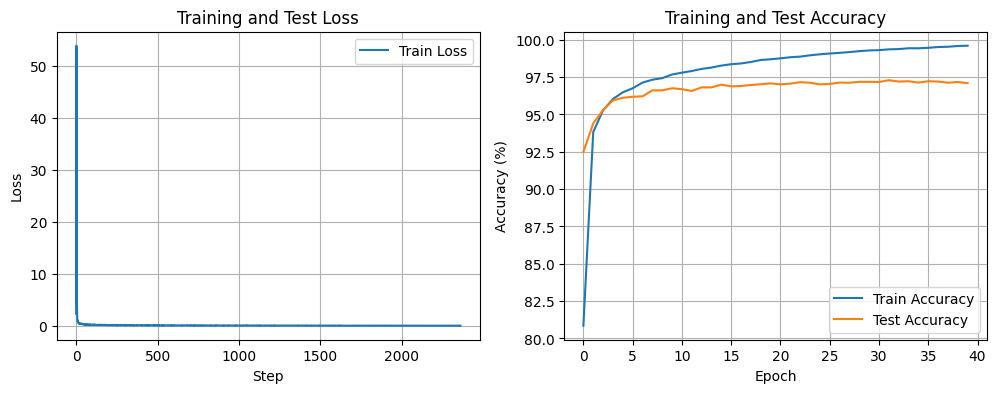

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

/tmp/ipython-input-3160626411.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


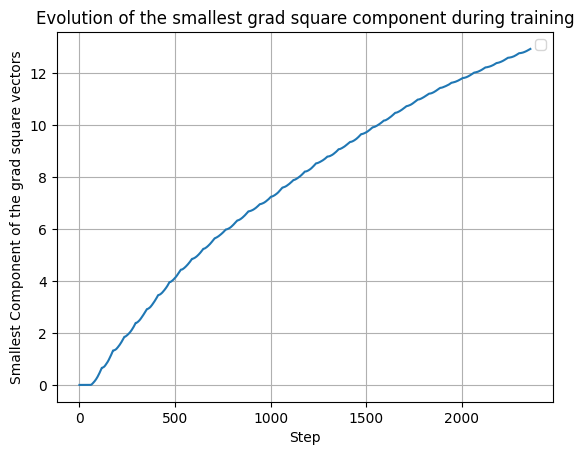

torch.Size([2360])
torch.Size([2360])


In [56]:
plt.title("Evolution of the smallest grad square component during training")
plt.xlabel("Step")
plt.ylabel("Smallest Component of the grad square vectors")
plt.plot(torch.cumsum(torch.tensor(cumulative_grad_squares), 0))
plt.grid(True)
plt.legend()
plt.show()
print(torch.tensor(cumulative_grad_squares).shape)
print(torch.cumsum(torch.tensor(cumulative_grad_squares), 0).shape)

In [57]:
# Final results for AdaGrad
final_test_loss, final_test_acc = test(model, testloader, criterion)
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')

Final Train Loss: 0.0197 | Final Train Acc: 99.67%
Final Test Loss: 0.1045 | Final Test Acc: 97.09%


# Adagrad with adaptive scheduling

In [13]:
num_epochs = 40
learning_rate = 1e-1

In [14]:
model = FCN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=85,  patience_up=15,  factor_up=5, factor_down= 5, factor_update=1.0)

In [15]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
cumulative_grad_squares = []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc, grad_squares = train_epoch(model, trainloader, criterion, optimizer, scheduler, grad_squares=True)
    test_loss, test_acc = test(model, testloader, criterion)
    

    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    cumulative_grad_squares += grad_squares

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 0.3034 | Train Acc: 78.93%
Test Loss: 0.2810 | Test Acc: 91.61%

Increasing LR: 0.100000 -> 0.500000
Decreasing LR: 0.500000 -> 0.100000
Epoch [2/40]
Train Loss: 0.5566 | Train Acc: 77.94%
Test Loss: 0.6107 | Test Acc: 83.72%

Epoch [3/40]
Train Loss: 0.4498 | Train Acc: 86.56%
Test Loss: 0.4243 | Test Acc: 89.09%

Increasing LR: 0.100000 -> 0.500000
Decreasing LR: 0.500000 -> 0.100000
Epoch [4/40]
Train Loss: 0.2981 | Train Acc: 87.86%
Test Loss: 0.3694 | Test Acc: 89.79%

Increasing LR: 0.100000 -> 0.500000
Epoch [5/40]
Train Loss: 0.3916 | Train Acc: 90.42%
Test Loss: 0.3655 | Test Acc: 89.77%

Decreasing LR: 0.500000 -> 0.100000
Epoch [6/40]
Train Loss: 0.2530 | Train Acc: 91.50%
Test Loss: 0.2846 | Test Acc: 91.88%

Increasing LR: 0.100000 -> 0.500000
Decreasing LR: 0.500000 -> 0.100000
Epoch [7/40]
Train Loss: 0.2578 | Train Acc: 92.07%
Test Loss: 0.2637 | Test Acc: 92.46%

Epoch [8/40]
Train Loss: 0.2095 | Train Acc: 93.03%
Test Lo

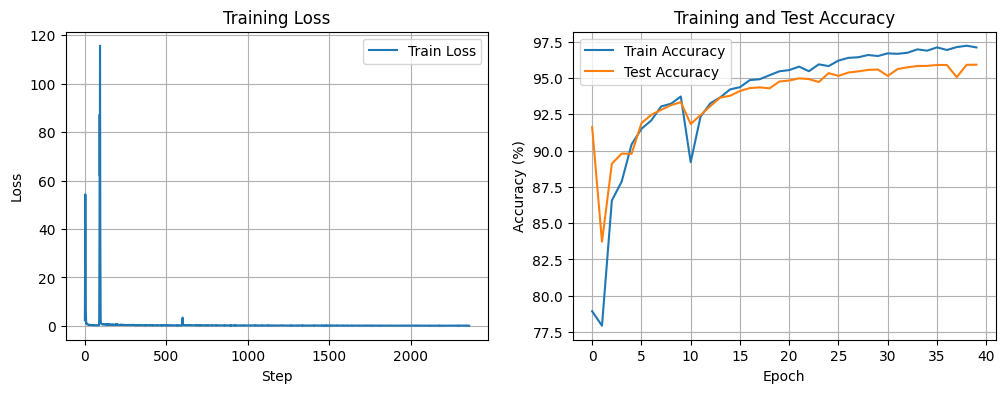

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

/tmp/ipython-input-3160626411.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


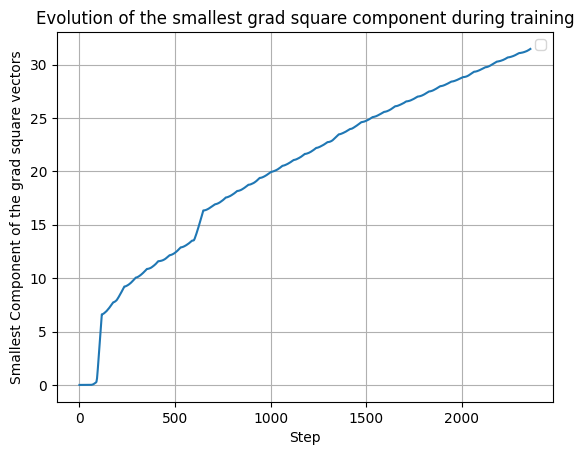

torch.Size([2360])
torch.Size([2360])


In [17]:
plt.title("Evolution of the smallest grad square component during training")
plt.xlabel("Step")
plt.ylabel("Smallest Component of the grad square vectors")
plt.plot(torch.cumsum(torch.tensor(cumulative_grad_squares), 0))
plt.grid(True)
plt.legend()
plt.show()
print(torch.tensor(cumulative_grad_squares).shape)
print(torch.cumsum(torch.tensor(cumulative_grad_squares), 0).shape)

In [18]:
# Final results for AdaGrad + Catapult
final_test_loss, final_test_acc = test(model, testloader, criterion)
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')

Final Train Loss: 0.0881 | Final Train Acc: 97.38%
Final Test Loss: 0.1473 | Final Test Acc: 95.91%


# Benchmark Catapult SGD vs Adam

To contextualize Catapult SGD within the landscape of modern optimizers, we compare its performance against **Adam**, one of the most widely-used adaptive methods. Since Adam inherently adapts its learning rate per parameter, applying Catapults to it is not applicable. This benchmark allows us to position Catapult SGD relative to state-of-the-art adaptive optimization methods.

In [47]:
num_epochs = 40
learning_rate = 1e-2

In [ ]:
model = FCN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # With Adam

# Patience to infinty
scheduler = CatapultScheduler(optimizer=optimizer, patience_down=torch.inf,  patience_up=torch.inf,  factor_up=10, factor_down= 10, factor_update=1.0)

In [49]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print('\nStarting training...\n')
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, scheduler)
    test_loss, test_acc = test(model, testloader, criterion)
    
    train_losses+= train_loss
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')


Starting training...

Epoch [1/40]
Train Loss: 0.1887 | Train Acc: 88.07%
Test Loss: 0.1610 | Test Acc: 95.18%

Epoch [2/40]
Train Loss: 0.1318 | Train Acc: 95.97%
Test Loss: 0.1172 | Test Acc: 96.44%

Epoch [3/40]
Train Loss: 0.0874 | Train Acc: 97.53%
Test Loss: 0.0850 | Test Acc: 97.40%

Epoch [4/40]
Train Loss: 0.0543 | Train Acc: 98.20%
Test Loss: 0.0783 | Test Acc: 97.51%

Epoch [5/40]
Train Loss: 0.0524 | Train Acc: 98.60%
Test Loss: 0.0774 | Test Acc: 97.71%

Epoch [6/40]
Train Loss: 0.0381 | Train Acc: 99.03%
Test Loss: 0.0835 | Test Acc: 97.60%

Epoch [7/40]
Train Loss: 0.0288 | Train Acc: 99.27%
Test Loss: 0.0757 | Test Acc: 97.77%

Epoch [8/40]
Train Loss: 0.0158 | Train Acc: 99.46%
Test Loss: 0.0772 | Test Acc: 97.77%

Epoch [9/40]
Train Loss: 0.0229 | Train Acc: 99.53%
Test Loss: 0.0790 | Test Acc: 97.89%

Epoch [10/40]
Train Loss: 0.0143 | Train Acc: 99.60%
Test Loss: 0.0882 | Test Acc: 97.53%

Epoch [11/40]
Train Loss: 0.0103 | Train Acc: 99.69%
Test Loss: 0.0825 | Tes

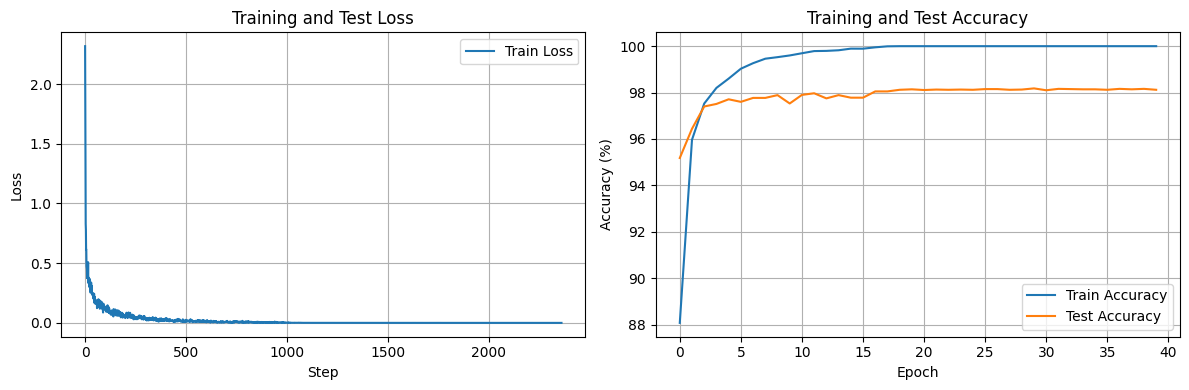

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [51]:
# Final results for Adam
final_test_loss, final_test_acc = test(model, testloader, criterion)
final_train_loss, final_train_acc = test(model, trainloader, criterion)
print(f'Final Train Loss: {final_train_loss:.4f} | Final Train Acc: {final_train_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Acc: {final_test_acc:.2f}%')

Final Train Loss: 0.0001 | Final Train Acc: 100.00%
Final Test Loss: 0.0941 | Final Test Acc: 98.12%


#### Summary: Test Accuracy Comparison

| Optimizer | Test Accuracy |
|-----------|---------------|
| SGD | 95.38% |
| SGD + Catapult | 97.65% |
| AdaGrad | 97.09% |
| AdaGrad + Catapult | 95.91%|
| Adam | 98.12% |

**Key Takeaways:**
- Catapults provide a consistent boost to SGD, improving test accuracy by **~2.3 percentage points**.
- SGD with Catapults achieves competitive performance with Adam on MNIST.
- Adam remains the best performer, though at higher computational cost per iteration.
- Catapults offer a simple, interpretable mechanism to enhance learning rate scheduling without the overhead of fully adaptive methods.